In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import os

# ==========================================
# [Configuration] 하이퍼파라미터 설정
# ==========================================
config = {
    'file_path': 'chirp_dataset.mat',
    'batch_size': 32,
    'lr': 0.001,
    'epochs': 20,
    'seed': 42,
    'val_ratio': 0.2,
    'test_ratio': 0.2,
    'fs': 100e6  # 100MHz
}

# GPU 설정 및 시드 고정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])

# PSNR 계산 함수 (Tensor 기반)
def calculate_psnr_tensor(pred, target):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return torch.tensor(100.0) # MSE가 0이면 PSNR은 무한대이므로 100으로 처리
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

print(f"✅ 실행 준비 완료 (장치: {device})")

✅ 실행 준비 완료 (장치: cuda)


📦 변수 목록: ['SNR_log', 'X_noisy', 'Y_clean']
✅ 데이터 로드 및 변환 성공! Shape: (5000, 1024)


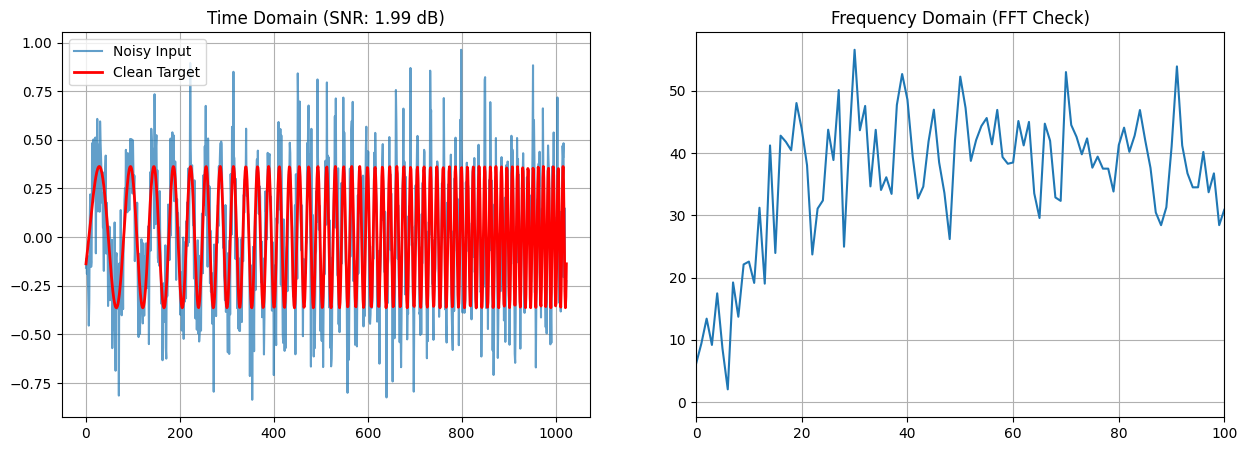

In [ ]:
try:
    with h5py.File(config['file_path'], 'r') as f:
        print(f"📦 변수 목록: {list(f.keys())}")
        
        # 1. Raw 데이터 로드 (Transpose 적용)
        X_raw = np.array(f['X_noisy']).T
        Y_raw = np.array(f['Y_clean']).T
        SNR_log = np.array(f['SNR_log']).T
        
        # 2. 복소수(Complex) 변환 함수
        def to_complex(data):
            if data.dtype.names is not None and 'real' in data.dtype.names:
                return data['real'] + 1j * data['imag']
            return data

        X_noisy_all = to_complex(X_raw)
        Y_clean_all = to_complex(Y_raw)

    print(f"✅ 데이터 로드 및 변환 성공! Shape: {X_noisy_all.shape}")

    # --- 샘플 데이터 시각화 ---
    idx = 0 
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.real(X_noisy_all[idx]), label='Noisy Input', alpha=0.7)
    plt.plot(np.real(Y_clean_all[idx]), 'r', label='Clean Target', linewidth=2)
    plt.title(f'Time Domain (SNR: {SNR_log[idx][0]:.2f} dB)')
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    fft_data = np.abs(np.fft.fft(X_noisy_all[idx]))
    plt.plot(fft_data)
    plt.title('Frequency Domain (FFT Check)'); plt.xlim(0, 100); plt.grid(True)
    plt.show()

except Exception as e:
    print(f"❌ 에러 발생: {e}")

In [27]:
class RadarDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # 딥러닝 입력을 위해 Real/Imag 2채널로 분할 [2, 1024]
        x_2ch = np.stack([np.real(self.x_data[idx]), np.imag(self.x_data[idx])], axis=0)
        y_2ch = np.stack([np.real(self.y_data[idx]), np.imag(self.y_data[idx])], axis=0)
        return torch.from_numpy(x_2ch).float(), torch.from_numpy(y_2ch).float()

# 데이터셋 객체 생성
full_dataset = RadarDataset(X_noisy_all, Y_clean_all)

# 분할 크기 계산
total_len = len(full_dataset)
val_len = int(total_len * config['val_ratio'])
test_len = int(total_len * config['test_ratio'])
train_len = total_len - val_len - test_len

# 데이터 분할
train_ds, val_ds, test_ds = random_split(
    full_dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(config['seed'])
)

# 로더 생성
train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=False)

print(f"📊 분할 결과 - Train: {train_len}, Val: {val_len}, Test: {test_len}")

📊 분할 결과 - Train: 3000, Val: 1000, Test: 1000


In [28]:
class RadarDenoiseNet(nn.Module):
    def __init__(self):
        super(RadarDenoiseNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=9, padding=4),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 2, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = RadarDenoiseNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

In [29]:
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')

print("🚀 학습 시작...")
for epoch in range(config['epochs']):
    # Training
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        running_train_loss += loss.item()
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            running_val_loss += criterion(outputs, labels).item()
            
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_denoise_model.pth')
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{config['epochs']}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

print("✨ 학습 완료!")

🚀 학습 시작...
Epoch [5/20] Train Loss: 0.003238 | Val Loss: 0.003252
Epoch [10/20] Train Loss: 0.002829 | Val Loss: 0.003623
Epoch [15/20] Train Loss: 0.002567 | Val Loss: 0.002555
Epoch [20/20] Train Loss: 0.002373 | Val Loss: 0.002215
✨ 학습 완료!


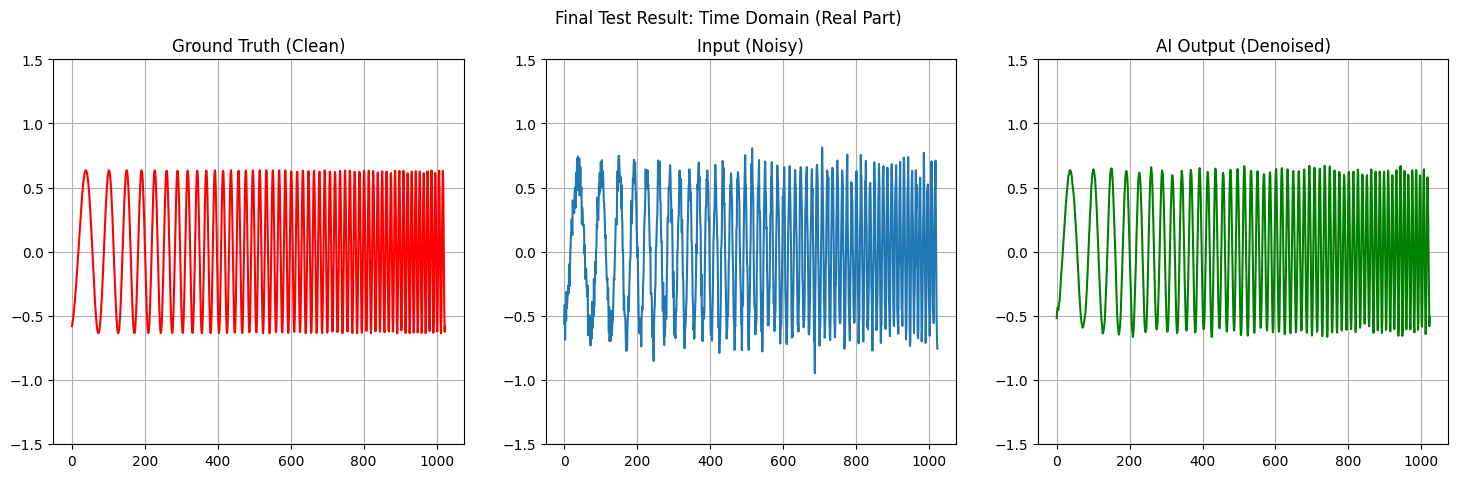

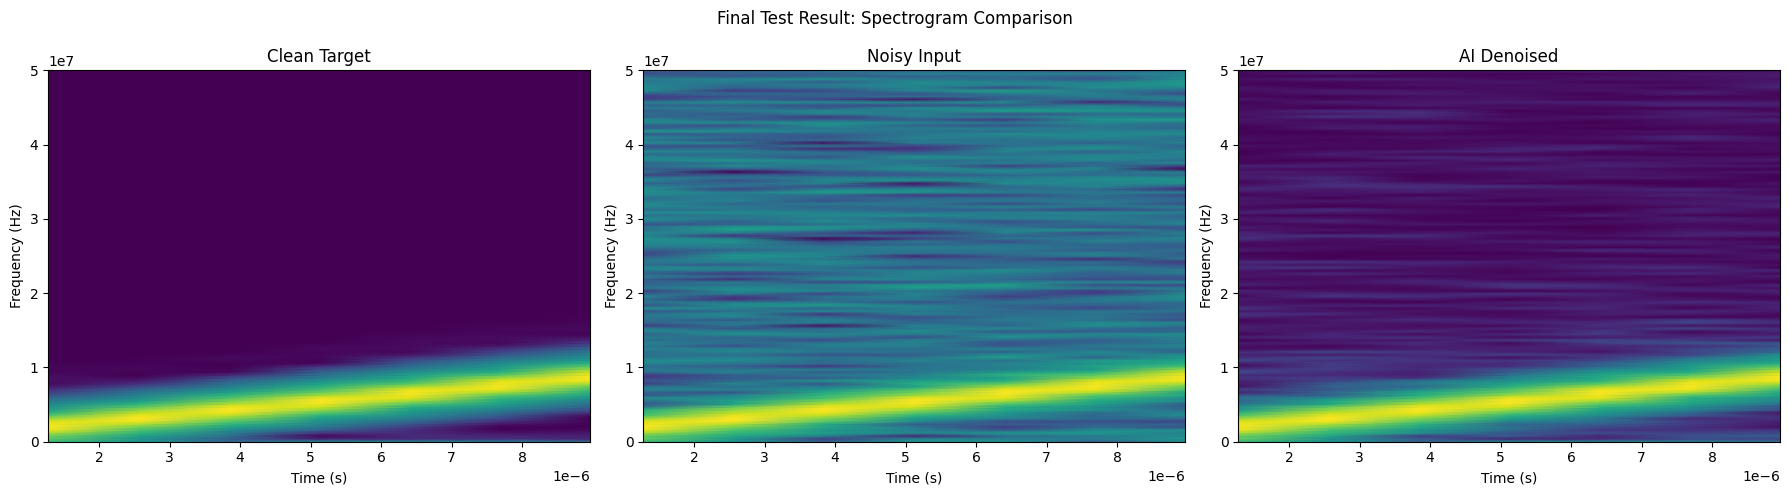

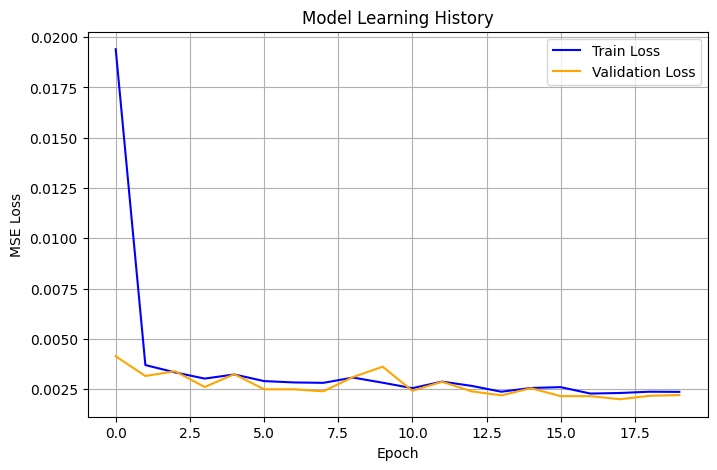

In [30]:
# 스펙트로그램 함수 정의
def plot_spectrogram(x, fs, title):
    f, t, Sxx = spectrogram(x, fs=fs, nperseg=256, noverlap=128)
    plt.pcolormesh(t, f, 10*np.log10(Sxx + 1e-12), shading='gouraud')
    plt.ylabel('Frequency (Hz)'); plt.xlabel('Time (s)'); plt.title(title)

# 1. 검증 과정에서 저장했던 '최적의 가중치'를 불러옵니다.
model.load_state_dict(torch.load('best_denoise_model.pth', weights_only=True))
model.eval() 

with torch.no_grad():
    # 2. 중요: 'test_loader'에서 데이터를 가져옵니다.
    test_in, test_target = next(iter(test_loader)) 
    test_in = test_in.to(device)
    
    # AI 모델로 예측 (Denoising)
    prediction = model(test_in)
    
    # 그래프를 그리기 위해 첫 번째 샘플(index 0)을 CPU로 가져옵니다.
    in_np = test_in[0].cpu().numpy()      # [2, 1024]
    target_np = test_target[0].cpu().numpy() # [2, 1024]
    pred_np = prediction[0].cpu().numpy()    # [2, 1024]

    # --- 신호 파형 비교 (Real Part) ---
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(target_np[0, :], 'r'); plt.title("Ground Truth (Clean)")
    plt.ylim(-1.5, 1.5); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(in_np[0, :]); plt.title("Input (Noisy)")
    plt.ylim(-1.5, 1.5); plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(pred_np[0, :], 'g'); plt.title("AI Output (Denoised)")
    plt.ylim(-1.5, 1.5); plt.grid(True)
    plt.suptitle("Final Test Result: Time Domain (Real Part)")
    plt.show()

    # --- 스펙트로그램 비교 ---
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1); plot_spectrogram(target_np[0, :], config['fs'], "Clean Target")
    plt.subplot(1, 3, 2); plot_spectrogram(in_np[0, :], config['fs'], "Noisy Input")
    plt.subplot(1, 3, 3); plot_spectrogram(pred_np[0, :], config['fs'], "AI Denoised")
    plt.suptitle("Final Test Result: Spectrogram Comparison")
    plt.tight_layout(); plt.show()

    # --- 학습 곡선 확인 ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_history, label='Train Loss', color='blue')
    plt.plot(val_loss_history, label='Validation Loss', color='orange')
    plt.title("Model Learning History")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend(); plt.grid(True)
    plt.show()